In [3]:
from google.colab import drive
drive.mount('/content/drive')
cwd = "drive/My Drive/IASD/projet_data_science/adversarial_attacks"
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, \
  Conv2D, Conv2DTranspose, UpSampling2D, BatchNormalization, \
  LeakyReLU, Dropout, Softmax, MaxPool2D, AveragePooling2D

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img

import tqdm
import tqdm.notebook

import random

import typing

import cv2

%tensorflow_version 2.x

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
labels = {
  0 : 'airplane',
  1 : 'automobile',
  2 : 'bird',
  3 : 'cat',
  4 : 'deer',
  5 : 'dog',
  6 : 'frog',
  7 : 'horse',
  8 : 'ship',
  9 : 'truck'
}

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

170500096/170498071 [==============================] - 4s 0us/step


#The refering model

### Loading the model from colab

In [0]:
path_model =  '/content/drive/My Drive/IASD/projet_data_science/adversarial_attacks/model_cifar.h5'
model_init = tf.keras.models.load_model(path_model)

### Training the model from scratch

In [0]:
from tensorflow.keras import models,layers

# Set seeds
tf.random.set_seed(94)
np.random.seed(94)

# Define model
model = models.Sequential(name='cifar')
model.add(layers.Conv2D(32, (4, 4), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (4, 4), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (4, 4), activation='relu'))
model.add(layers.AveragePooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))


model.summary()

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)


# Compile and fit
model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=15,validation_data=(x_test, y_test))

# Plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test, y_test)

# Function to define the CNNs

In [0]:
class ModelConfig(typing.NamedTuple):
  conv_layers: typing.List
  dense_layers: typing.List
  epochs: int = 1

def create_model(config: ModelConfig):
    inp = Input(shape=(32, 32, 3))

    np.random.seed(37)
    tf.random.set_seed(37)
    
    x = inp

    for filters, kernel_size in config.conv_layers:
      x = Conv2D(filters=filters, kernel_size=(kernel_size, kernel_size), activation='relu')(x)
      x = MaxPool2D((2,2))(x)

    x = Flatten()(x)

    for nb_units, activation in config.dense_layers:
      x = Dense(units=nb_units, activation=activation)(x)
      
    
    model = tf.keras.Model(
        inputs=inp,
        outputs=x,
        name="lenet")


    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


    model.compile(optimizer='adam',
              loss=loss,
              metrics=['accuracy'])

    return model

# Implementation of FGSM & PGD attacks

In [0]:
class Attack():

  def __init__(self,model):
    self.model = model



  def fgsm(self,image,label,eta=0.01):
    img = np.expand_dims(image,axis=0)
    self.image = tf.convert_to_tensor(img)
    #self.image = tf.convert_to_tensor(image)
    self.label = label
    self.eta = eta

    with tf.GradientTape() as tape:
        tape.watch(self.image)
        prediction = self.model(self.image)
        loss = tf.keras.losses.MSE(self.label, prediction)

    gradient = tape.gradient(loss, self.image)
    signed_grad = tf.sign(gradient)

    attacked_image = self.image + self.eta * signed_grad

    #retourne un tenseur avec l'image attaquée
    return np.squeeze(attacked_image.numpy(),axis=0)
    

  def pgd(self,image,label,eps,eta,n_iter):
    #img = np.expand_dims(image,axis=0)
    #self.image = tf.convert_to_tensor(img)
    self.image = image
    self.label = label
    self.eta = eta
    self.eps = eps
    self.n_iter = n_iter
    self.eta = eta

    x_adversarial = self.image

    for iter in range(self.n_iter): 
      x_adversarial = self.fgsm(x_adversarial,self.label,self.eta)
      x_adversarial = tf.clip_by_value(x_adversarial, clip_value_min= x_adversarial-self.eps, clip_value_max= x_adversarial+self.eps)
      #self.image = x_adversarial

    return x_adversarial.numpy()

In [0]:
class Attack_batch():

  def __init__(self,model):
    self.model = model


  def fgsm(self,batch,batch_labels,eta):
    self.batch = tf.convert_to_tensor(batch)
    self.batch_labels = batch_labels
    self.eta = eta



    with tf.GradientTape() as tape:
        tape.watch(self.batch)
        prediction = self.model(self.batch)
        loss = tf.keras.losses.MSE(self.batch_labels, prediction)

    gradient = tape.gradient(loss, self.batch)
    signed_grad = tf.sign(gradient)

    attacked_image = batch + self.eta * signed_grad
    #retourne un tenseur avec l'image attaquée
    return attacked_image.numpy()
    

  def pgd(self,batch,batch_labels,epsilon,eta,n_iter):
    self.batch = tf.convert_to_tensor(batch)
    self.batch_labels = batch_labels
    self.eta = eta
    self.epsilon = epsilon
    self.n_iter = n_iter


    x_adversarial = self.batch

    for iter in range(self.n_iter): 
      x_adversarial = self.fgsm(x_adversarial,self.batch_labels,self.eta)
      x_adversarial = tf.clip_by_value(x_adversarial, clip_value_min= x_adversarial-self.epsilon, clip_value_max= x_adversarial+self.epsilon)

    return x_adversarial.numpy()

# Visualizing the attacks

In [0]:
def show_prediction(x, y, model):

  plt.figure(figsize=(16, 8))
  for i in range(0, 18):
      plt.subplot(3, 6, i + 1)
      plt.imshow(x[i])
      plt.text(0, 2, s=f"y_true={labels[y[i][0]]}",
              bbox=dict(facecolor='blue', alpha=0.9),
              color="white")
      
      prediction = model.predict(np.expand_dims(x[i], 0))
      prediction = np.argmax(prediction)

      color = "green" if prediction == y[i][0] else "red"
      
      plt.text(0, 26, s=f"y_pred={labels[prediction]}",
              bbox=dict(facecolor=color, alpha=0.9),
              color="white")

      plt.axis("off")
  plt.show()


def show_fgsm_attack(x, y, model,eta):

  plt.figure(figsize=(16, 8))
  for i in range(0, 18):
      attack = Attack(model)
      plt.subplot(3, 6, i + 1)
      img = attack.fgsm(x[i],y[i],eta)
      plt.imshow((img*255).astype(np.uint8))
      #plt.imshow(img)
      plt.text(0, 2, s=f"y_true={labels[y[i][0]]}",
              bbox=dict(facecolor='blue', alpha=0.9),
              color="white")
      
      prediction = model.predict(np.expand_dims(img, 0))
      prediction = np.argmax(prediction)

      color = "green" if prediction == y[i][0] else "red"
      
      plt.text(0, 26, s=f"y_pred={labels[prediction]}",
              bbox=dict(facecolor=color, alpha=0.9),
              color="white")

      plt.axis("off")
  plt.show()


def show_pgd_attack(x, y, model,eps,eta,n_iter):

  plt.figure(figsize=(16, 8))
  for i in range(0, 18):
      attack = Attack(model)
      plt.subplot(3, 6, i + 1)
      img = attack.pgd(x[i],y[i],eps,eta,n_iter)
      plt.imshow((img*255).astype(np.uint8))
      #plt.imshow(img)
      plt.text(0, 2, s=f"y_true={labels[y[i][0]]}",
              bbox=dict(facecolor='blue', alpha=0.9),
              color="white")
      
      prediction = model.predict(np.expand_dims(img, 0))
      prediction = np.argmax(prediction)

      color = "green" if prediction == y[i][0] else "red"
      
      plt.text(0, 26, s=f"y_pred={labels[prediction]}",
              bbox=dict(facecolor=color, alpha=0.9),
              color="white")

      plt.axis("off")
  plt.show()


### Visualizing the original images

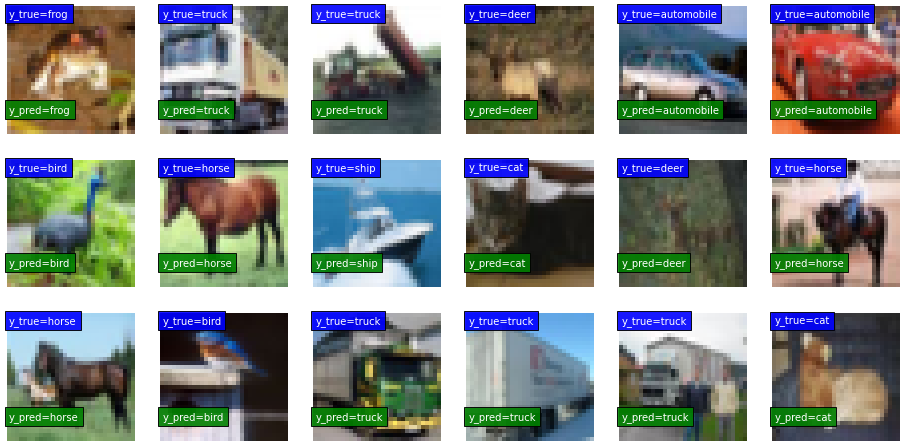

In [11]:
show_prediction(x_train,y_train,model_init)

### Visualizing FGSM attacks

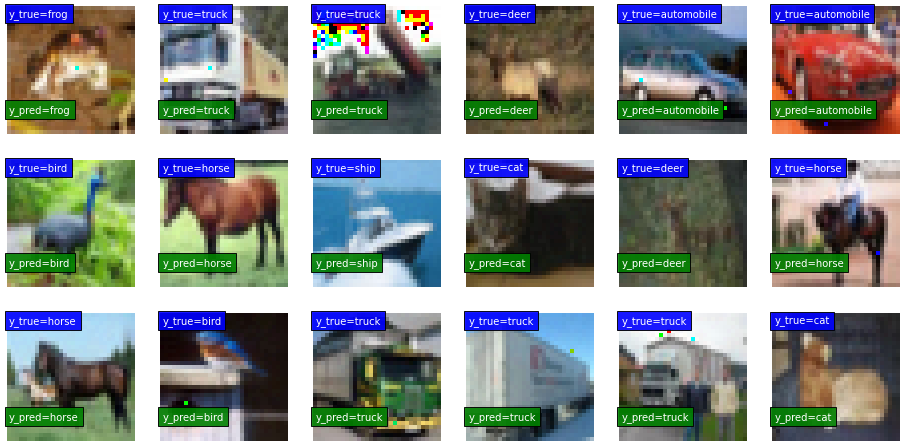

In [18]:
show_fgsm_attack(x_train,y_train,model_init,eta=2/255)

### Visualizing PGD attacks

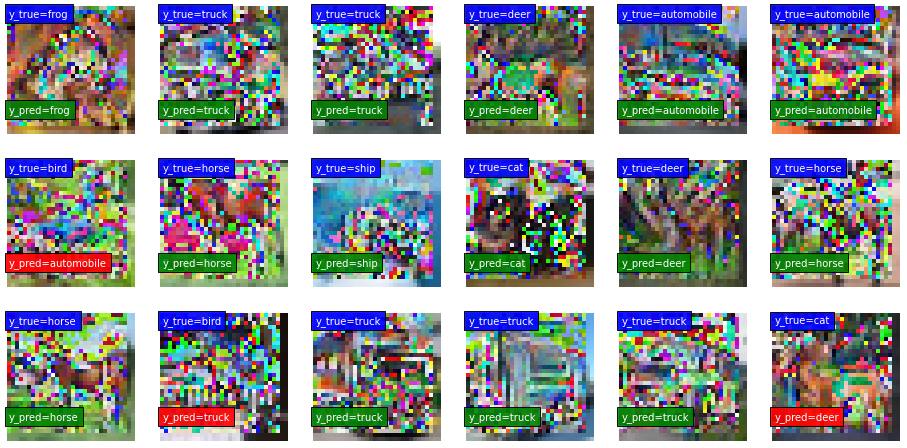

In [20]:
show_pgd_attack(x_train,y_train,model_init,eps=8/255,eta=2/255,n_iter=50)

## FGSM: the parameter eta

313/313 [==============================] - 1s 3ms/step - loss: 3.4439 - accuracy: 0.7310


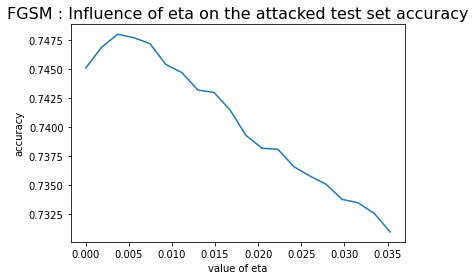

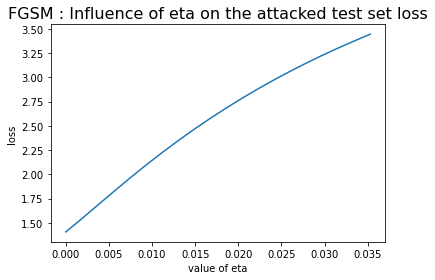

In [0]:
attack = Attack_batch(model_init)


val_eta = np.linspace(0,9/255,20)

loss_eta = []
acc_eta = []



for eta in val_eta:
  adv = attack.fgsm(x_test,y_test,eta) 
  t = model_init.evaluate(adv,y_test)
  loss_eta.append(t[0])
  acc_eta.append(t[1])


plt.plot(val_eta,acc_eta)
plt.xlabel('value of eta')
plt.ylabel('accuracy')
plt.title('FGSM : Influence of eta on the attacked test set accuracy',fontdict={'fontsize':16})
plt.show()

plt.plot(val_eta,loss_eta)
plt.xlabel('value of eta')
plt.ylabel('loss')
plt.title('FGSM : Influence of eta on the attacked test set loss',fontdict={'fontsize':16})
plt.show()

## PGD

### Parameter eta

In [0]:
attack = Attack_batch(model_init)

epsilon=9/255
n_iter=7

val_eta = np.linspace(0,9/255,10)
pgd_acc_eta = []
pgd_loss_eta = []


for eta in val_eta:
  adv = attack.pgd(x_test,y_test,epsilon,eta,n_iter)
  t = model_init.evaluate(adv,y_test)

  pgd_acc_eta.append(t[1])
  pgd_loss_eta.append(t[0])
  

313/313 [==============================] - 1s 3ms/step - loss: 30.9563 - accuracy: 0.6108


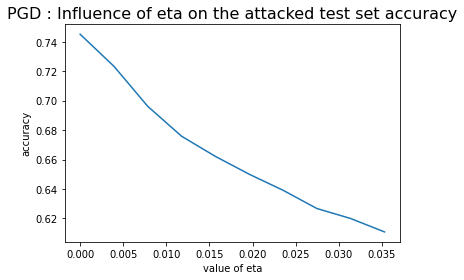

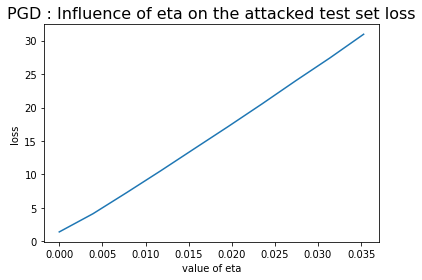

In [0]:
plt.plot(val_eta,pgd_acc_eta)
plt.xlabel('value of eta')
plt.ylabel('accuracy')
plt.title('PGD : Influence of eta on the attacked test set accuracy',fontdict={'fontsize':16})
plt.show()

plt.plot(val_eta,pgd_loss_eta)
plt.xlabel('value of eta')
plt.ylabel('loss')
plt.title('PGD : Influence of eta on the attacked test set loss',fontdict={'fontsize':16})
plt.show()

### Parameter epsilon

In [0]:
attack = Attack_batch(model_init)
eta=5/255
n_iter=7
eps= 10/255
#val_eps = np.linspace(0,9/255,20)
#acc_eps = []
#loss_eps = []


adv = attack.pgd(x_test,y_test,epsilon=10/255,eta=5/255,n_iter=n_iter)
model_init.evaluate(adv,y_test)

adv = attack.pgd(x_test,y_test,epsilon=100/255,eta=5/255,n_iter=n_iter)
model_init.evaluate(adv,y_test)

313/313 [==============================] - 1s 3ms/step - loss: 17.2087 - accuracy: 0.6470


[17.208709716796875, 0.6470000147819519]

In [0]:
attack = Attack_batch(model_init)
eta=3/255
n_iter=7

val_eps = np.linspace(0,9/255,20)
acc_eps = []
loss_eps = []


for eps in val_eps:
  adv = attack.pgd(x_test,y_test,eps,eta,n_iter)
  t = model_init.evaluate(adv,y_test)
  acc_eps.append(t[1])
  loss_eps.append(t[0])

plt.plot(val_eps,acc_eps)
plt.xlabel('value of epsilon')
plt.ylabel('accuracy')
plt.title('PGD : Influence of epsilon on the attacked test set accuracy',fontdict={'fontsize':16})
plt.show()

plt.plot(val_eps,loss_eps)
plt.xlabel('value of epsilon')
plt.ylabel('loss')
plt.title('PGD : Influence of epsilon on the attacked test set loss',fontdict={'fontsize':16})
plt.show()



159/313 [==============>...............] - ETA: 0s - loss: 10.4469 - accuracy: 0.6818

KeyboardInterrupt: ignored

### Parameter number of iterations

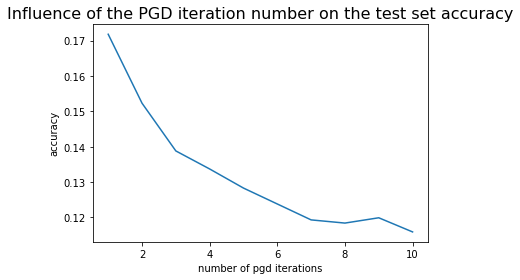

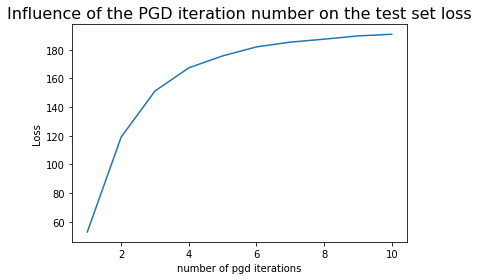

In [0]:
attack = Attack(model)

n_iters = [i for i in range(1,11)]
acc_n = []
loss_n = []

for n_iter in n_iters:
  adv = np.array([attack.pgd(x_test[i],y_test[i],1,10,n_iter) for i in tqdm.notebook.tqdm(range(len(x_test)))])
  t = model.evaluate(adv,y_test)
  acc_n.append(t[1])
  loss_n.append(t[0])
#x_test_adv = np.array([np.squeeze(attack.fgsm(x_test[i],y_test[i],eta),axis=0) for i in tqdm.notebook.tqdm(range(len(x_test)))])


plt.plot(n_iters,acc_n, label = 'test_loss')
plt.xlabel('number of pgd iterations')
plt.ylabel('accuracy')
plt.title('Influence of the PGD iteration number on the test set accuracy',fontdict={'fontsize':16})
plt.show()

plt.plot(n_iters,loss_n, label = 'test_loss')
plt.xlabel('number of pgd iterations')
plt.ylabel('Loss')
plt.title('Influence of the PGD iteration number on the test set loss',fontdict={'fontsize':16})
plt.show()

# Black Box Attacks

In this section, we attack our test set with different CNN. We aim at understanding the influence of the number of convolution layers as well as the number of filters on an attack. 

## Number of conv layers

In the code below, we train 5 CNN with 1 to 5 layers with the same number of filters. For each of these CNN, we attack the CIFAR-10 test set and we evaluate the loss and accuracy for the initial model.

In [21]:
dict_models = {'model':[],'history':[]}

for conv_layer in range(1,5) :
    print(f'training {conv_layer}')
    config = ModelConfig(
        conv_layers=[(64, 2)]*conv_layer,
        dense_layers=[(256, "relu"), (10, None)]
    )

    model = create_model(config)
    
    history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_test, y_test),verbose=0)
    
    dict_models['model'].append(model)
    dict_models['history'].append(history.history)

training 1
training 2
training 3
training 4


### Performances of the networks

Text(0.5, 1.0, 'Test set accuracy of the trained models ')

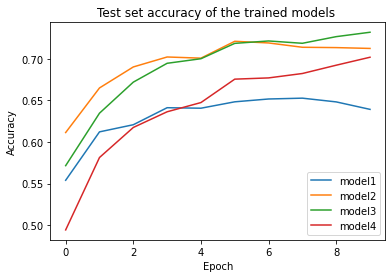

In [22]:
for i in range(len(dict_models['model'])) :
  h = dict_models['history'][i]['val_accuracy']
  plt.plot(h , label= 'model'+str(i+1))

plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Test set accuracy of the trained models ",fontdict={'fontsize':12})
plt.show()

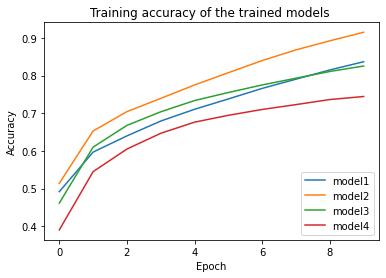

In [28]:
for i in range(len(dict_models['model'])) :
  h = dict_models['history'][i]['accuracy']
  plt.plot(h , label= 'model'+str(i+1))

plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training accuracy of the trained models ",fontdict={'fontsize':12})
plt.show()

### Using FGSM attacks

313/313 [==============================] - 1s 2ms/step - loss: 1.9881 - accuracy: 0.7468


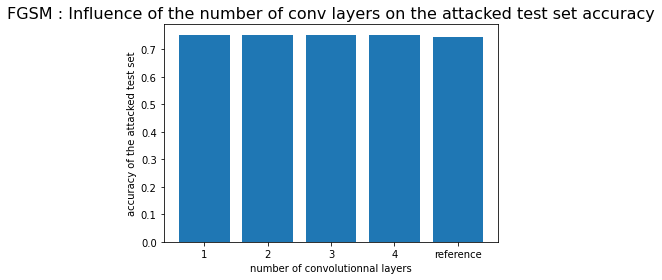

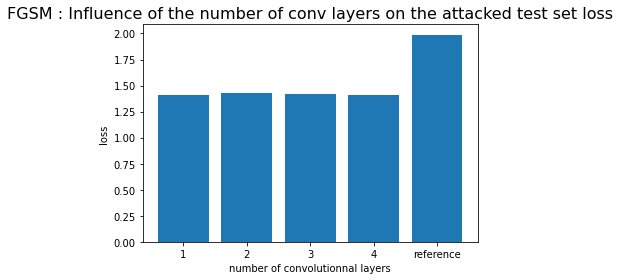

In [23]:
adv_test_acc_layers = []
adv_test_loss_layers = []

eta = 2/255

nb_conv_layers = 1
for model in dict_models['model']:
  
    attack_batch = Attack_batch(model)
    adv = attack_batch.fgsm(x_test,y_test,eta=eta)
    p = model_init.evaluate(adv,y_test)
    
    adv_test_loss_layers.append(p[0])
    adv_test_acc_layers.append(p[1])
    
    del attack_batch
    del adv

attack_batch = Attack_batch(model_init)
adv = attack_batch.fgsm(x_test,y_test,eta=eta)
p = model_init.evaluate(adv,y_test)

adv_test_loss_layers.append(p[0])
adv_test_acc_layers.append(p[1])

plt.bar([str(i+1) for i in range(len(adv_test_acc_layers)-1)]+['reference'],adv_test_acc_layers)
plt.xlabel('number of convolutionnal layers')
plt.ylabel('accuracy of the attacked test set')
plt.title('FGSM : Influence of the number of conv layers on the attacked test set accuracy',fontdict={'fontsize':16})
plt.show()

plt.bar([str(i+1) for i in range(len(adv_test_loss_layers)-1)]+['reference'],adv_test_loss_layers)
plt.xlabel('number of convolutionnal layers')
plt.ylabel('loss')
plt.title('FGSM : Influence of the number of conv layers on the attacked test set loss',fontdict={'fontsize':16})
plt.show()

### Using PGD attacks

313/313 [==============================] - 1s 2ms/step - loss: 67.6424 - accuracy: 0.5640


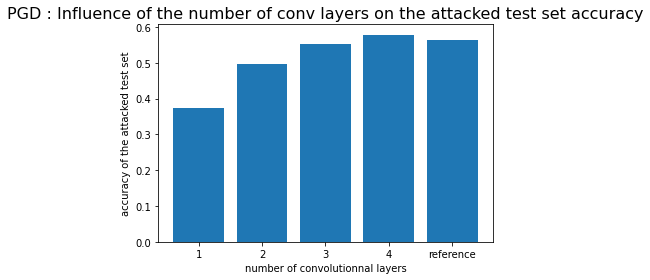

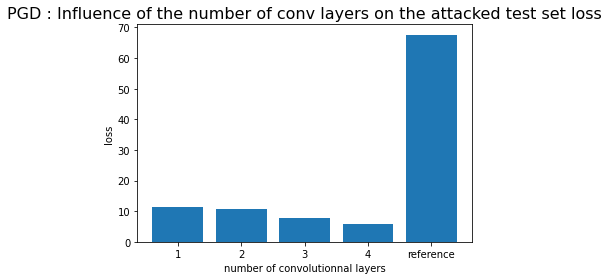

In [29]:
adv_test_acc_layers = []
adv_test_loss_layers = []

eta = 2/255
epsilon = 8/255 
nb_conv_layers = 3

##Attacking the image test set with the previous trained networks
##Evaluating the attacks with our reference model

for model in dict_models['model']:
  
    attack_batch = Attack_batch(model)
    adv = attack_batch.pgd(x_test,y_test,epsilon= epsilon,eta=eta,n_iter=50)
    p = model_init.evaluate(adv,y_test)
    
    adv_test_loss_layers.append(p[0])
    adv_test_acc_layers.append(p[1])

##Attack the image test set with our reference model
##Evaluating the attacks with our reference model

attack_batch = Attack_batch(model_init)
adv = attack_batch.pgd(x_test,y_test,epsilon= epsilon,eta=eta,n_iter=50)
p = model_init.evaluate(adv,y_test)

adv_test_loss_layers.append(p[0])
adv_test_acc_layers.append(p[1])

plt.bar([str(i+1) for i in range(len(adv_test_acc_layers)-1)]+['reference'],adv_test_acc_layers)
plt.xlabel('number of convolutionnal layers')
plt.ylabel('accuracy of the attacked test set')
plt.title('PGD : Influence of the number of conv layers on the attacked test set accuracy',fontdict={'fontsize':16})
plt.show()

plt.bar([str(i+1) for i in range(len(adv_test_loss_layers)-1)]+['reference'],adv_test_loss_layers)
plt.xlabel('number of convolutionnal layers')
plt.ylabel('loss')
plt.title('PGD : Influence of the number of conv layers on the attacked test set loss',fontdict={'fontsize':16})
plt.show()

The plots above seem to highlight a decrease of the accuracy of the attacked test set with respect with the increase of the depth of the CNN. 
However, the trend of the loss is quite unexpected.

## Number of filters

We repeat the same experience with different numbers of filter. In this way, we train 7 CNN, with 3 layers. For each of the CNN the number of filter varies from 8 to 512.
Then, we attack the CIFAR-10 test set and we evaluate the loss and accuracy of the initial model.

In [12]:
dict_models_filters = {'model':[],'history':[]}

filters = [8,16,32,64,128,256,512]


step = 1
for filt in filters :
    print(f"etape {step}") 
    config = ModelConfig(
        conv_layers=[(filt, 2)]*3,
        dense_layers=[(256, "relu"), (10, None)]
    )

    model = create_model(config)
    dict_models_filters['model'].append(model)


    history = model.fit(x_train, y_train, epochs=10,
                    validation_data=(x_test, y_test),verbose=0)
    dict_models_filters['history'].append(history.history)

    step += 1 

etape 1
etape 2
etape 3
etape 4
etape 5
etape 6
etape 7


Text(0.5, 1.0, 'Training accuracy of the trained models ')

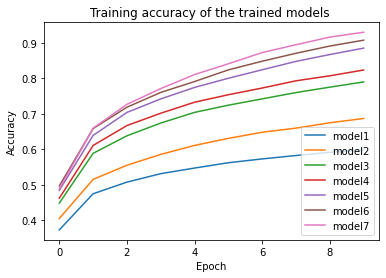

In [80]:
for i in range(len(dict_models_filters['model'])) :
  h = dict_models_filters['history'][i]['accuracy']
  plt.plot(h , label= 'model'+str(i+1))

plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training accuracy of the trained models ",fontdict={'fontsize':12})

Text(0.5, 1.0, 'Test set accuracy of the trained models ')

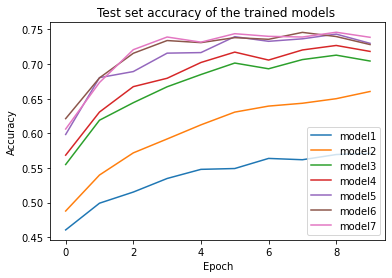

In [15]:
for i in range(len(dict_models_filters['model'])) :
  h = dict_models_filters['history'][i]['val_accuracy']
  plt.plot(h , label= 'model'+str(i+1))

plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Test set accuracy of the trained models ",fontdict={'fontsize':12})

### Using FGSM attacks

32/32 [==============================] - 0s 3ms/step - loss: 1.3438 - accuracy: 0.7570


I0505 10:00:38.744699 139683438802816 category.py:219] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0505 10:00:38.746471 139683438802816 category.py:219] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


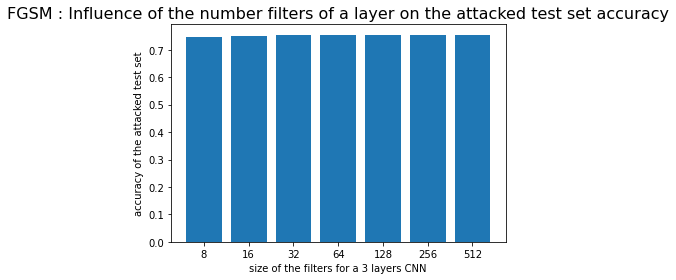

I0505 10:00:38.931068 139683438802816 category.py:219] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0505 10:00:38.933022 139683438802816 category.py:219] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


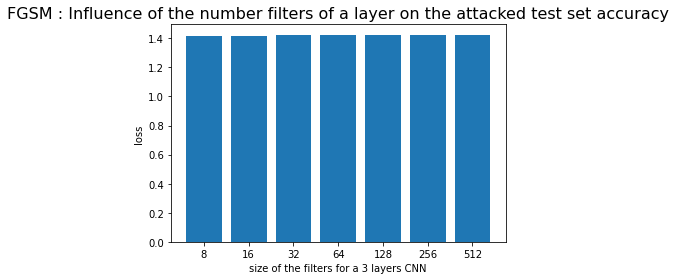

In [82]:
adv_test_acc_filters = []
adv_test_loss_filters = []

eta = 2/255

filters = [8,16,32,64,128,256,512]

l = np.linspace(0,10000,11,dtype=int)

for i in range(len(dict_models_filters['model'])):
    model = dict_models_filters['model'][i]
    attack = Attack_batch(model)
    if i >= 2 : 
      loss = []
      acc = []

      model = dict_models_filters['model'][6]
      attack = Attack_batch(model)

      for i in range(len(l)-1):  
          adv = attack.fgsm(x_test[l[i]:l[i+1]],y_test[l[i]:l[i+1]],eta)
          p = model_init.evaluate(adv,y_test[l[i]:l[i+1]])
          loss.append(p[0])
          acc.append(p[1])

      adv_test_loss_filters.append(np.mean(loss))
      adv_test_acc_filters.append(np.mean(acc))
    else : 
      adv = attack.fgsm(x_test,y_test,eta)
      p = model_init.evaluate(adv,y_test)
      adv_test_loss_filters.append(p[0])
      adv_test_acc_filters.append(p[1])

plt.bar([str(i) for i in filters],adv_test_acc_filters)
plt.xlabel('size of the filters for a 3 layers CNN')
plt.ylabel('accuracy of the attacked test set')
plt.title('FGSM : Influence of the number filters of a layer on the attacked test set accuracy',fontdict={'fontsize':16})
plt.show()

plt.bar([str(i) for i in filters],adv_test_loss_filters)
plt.xlabel('size of the filters for a 3 layers CNN')
plt.ylabel('loss')
plt.title('FGSM : Influence of the number filters of a layer on the attacked test set accuracy',fontdict={'fontsize':16})
plt.show()

### Using PGD attacks

In [77]:
adv_test_acc_filters = []
adv_test_loss_filters = []

eta = 2/255
epsilon = 8/255 
n=50

filters = [8,16,32,64,128,256,512]

l = np.linspace(0,10000,11,dtype=int)

for i in range(len(dict_models_filters['model'])):
    model = dict_models_filters['model'][i]
    attack = Attack_batch(model)
    if i >= 2 : 
      loss = []
      acc = []

      model = dict_models_filters['model'][6]
      attack = Attack_batch(model)

      for i in range(len(l)-1):  
          adv = attack.pgd(x_test[l[i]:l[i+1]],y_test[l[i]:l[i+1]],epsilon,eta,n)
          p = model_init.evaluate(adv,y_test[l[i]:l[i+1]])
          loss.append(p[0])
          acc.append(p[1])

      adv_test_loss_filters.append(np.mean(loss))
      adv_test_acc_filters.append(np.mean(acc))
    else : 
      adv = attack.pgd(x_test,y_test,epsilon,eta,n_iter=n)
      p = model_init.evaluate(adv,y_test)
      adv_test_loss_filters.append(p[0])
      adv_test_acc_filters.append(p[1])

32/32 [==============================] - 0s 3ms/step - loss: 7.1542 - accuracy: 0.6030


I0505 09:59:44.772277 139683438802816 category.py:219] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0505 09:59:44.775226 139683438802816 category.py:219] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


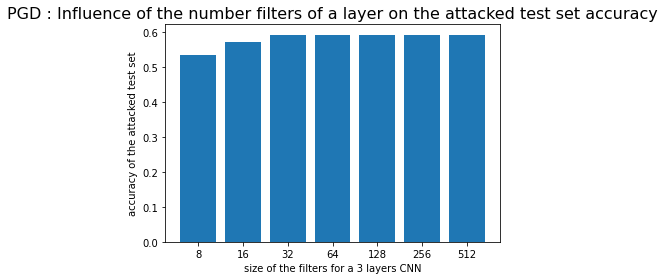

I0505 09:59:44.962864 139683438802816 category.py:219] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
I0505 09:59:44.965274 139683438802816 category.py:219] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


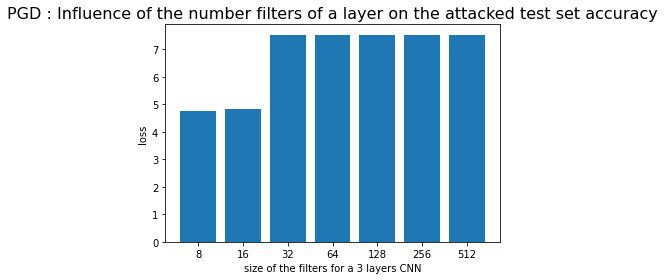

In [81]:
plt.bar([str(i) for i in filters],adv_test_acc_filters)
plt.xlabel('size of the filters for a 3 layers CNN')
plt.ylabel('accuracy of the attacked test set')
plt.title('PGD : Influence of the number filters of a layer on the attacked test set accuracy',fontdict={'fontsize':16})
plt.show()

plt.bar([str(i) for i in filters],adv_test_loss_filters)
plt.xlabel('size of the filters for a 3 layers CNN')
plt.ylabel('loss')
plt.title('PGD : Influence of the number filters of a layer on the attacked test set accuracy',fontdict={'fontsize':16})
plt.show()

#Attempt to visualize the adversarial attacks

## Grad-cam implementation

In [0]:
def grad_cam(model,layer_name,img,num_label):
 
    grad_model = tf.keras.models.Model([model.input], [model.get_layer(name= layer_name).output,model.output])

    with tf.GradientTape() as g:
        conv_outputs,predictions = grad_model(np.array([img]))
        loss = predictions[:, num_label]
        
    output = conv_outputs[0]
    grads = g.gradient(loss, conv_outputs)[0]

    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.ones(output.shape[0: 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]


    cam = cv2.resize(cam.numpy(), (32, 32))
    check = cam
    cam = np.maximum(cam, 0)

    heatmap = (cam - cam.min()) / (cam.max() - cam.min())


    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_VIRIDIS)

    output_image = cv2.addWeighted(cv2.cvtColor(np.uint8(img*255), cv2.COLOR_RGB2BGR), 0.3, cam, 0.7, 0)

    return cam , output_image


## Grad-cam visualization

In [0]:
layer_name = 'conv2d_27'
epsilon = 30./255
eta = 6./255
n_iter = 10

img_start = 5000
img_end = 5200

def pgd_grad_cam_visualization(img_start,img_end,layer_name,epsilon,eta,n_iter) :
  
    for ind in range(img_start,img_end):
        l = []
        image = x_test[ind]
        l.append(np.uint8(image*255))
        num_label = y_test[ind][0]
        gc = grad_cam(model_init,layer_name,image,num_label)
        l.append(gc[0])
        l.append(gc[1])

        attack = Attack(model_init)
        adv_image = np.uint8(attack.pgd(image,y_test[ind],epsilon,eta,n_iter)*255)
        l.append(adv_image)

        label_image = y_test[ind][0]
        predicted_label = np.argmax(model_init(tf.expand_dims(image,0)))
        confidence = tf.math.softmax(model_init(tf.expand_dims(image,0)))[:,predicted_label]*100

        predicted_label_attack = np.argmax(model_init(tf.expand_dims(adv_image,0)))
        confidence_attack = tf.math.softmax(model_init(tf.expand_dims(adv_image,0)))[:,predicted_label_attack]*100


        gc_adv = grad_cam(model_init,layer_name,adv_image,np.argmax(model_init(tf.expand_dims(adv_image,0))))
        l.append(gc_adv[0])
        l.append(gc_adv[1])

        
        titles = ["Initial image prediction",
                  "GRAD-CAM heatmap on the initial image",
                  "GRAD-CAM on the initial image",
                  "Attacked image prediction",
                  "GRAD-CAM heatmap on the attacked image",
                  "GRAD-CAM on the attacked image"]

        fig = plt.figure(figsize=(16, 8))

        for i in range(0,6):
          plt.subplot(2, 3, i + 1)
          if i in range(0,3):
            plt.imshow(l[i])
            plt.text(0, 2, s=f"y_true={labels[label_image]}",
                    bbox=dict(facecolor='blue', alpha=0.9),
                    color="white")
            color = "green" if predicted_label == label_image else "red"
            plt.text(0, 26, s=f"y_pred={labels[predicted_label]} confidence={confidence}",
                  bbox=dict(facecolor=color, alpha=0.9),
                  color="white")

          else : 
            plt.text(0, 2, s=f"y_true={labels[label_image]}",
            bbox=dict(facecolor='blue', alpha=0.9),
            color="white")
            color_adv = "green" if predicted_label == predicted_label_attack else "yellow"
            plt.imshow(l[i])
            plt.text(0, 28, s=f"y_attacked={labels[predicted_label_attack]} confidence={confidence_attack}",
                    bbox=dict(facecolor=color_adv, alpha=0.9),
                    color="black")
            
          plt.title(titles[i],fontdict={'fontsize':12})
          plt.axis("off")

        plt.show()

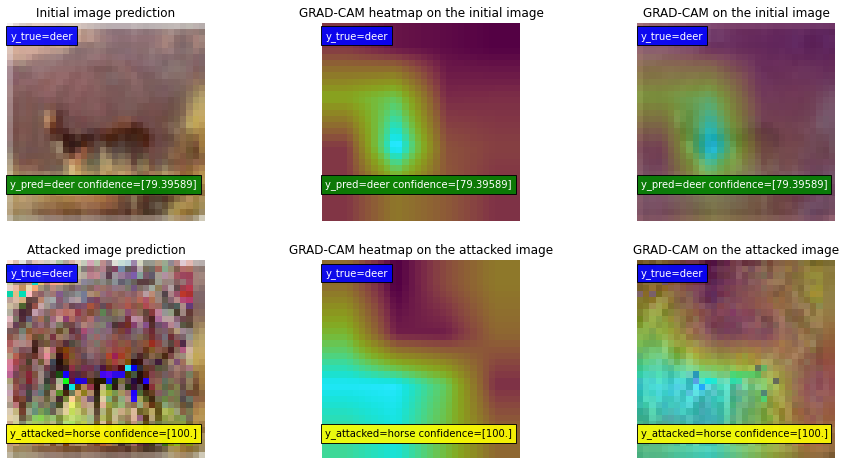

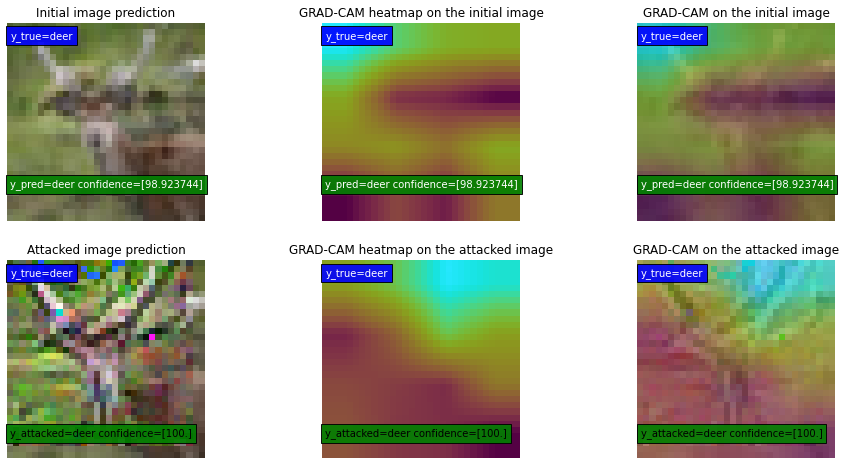

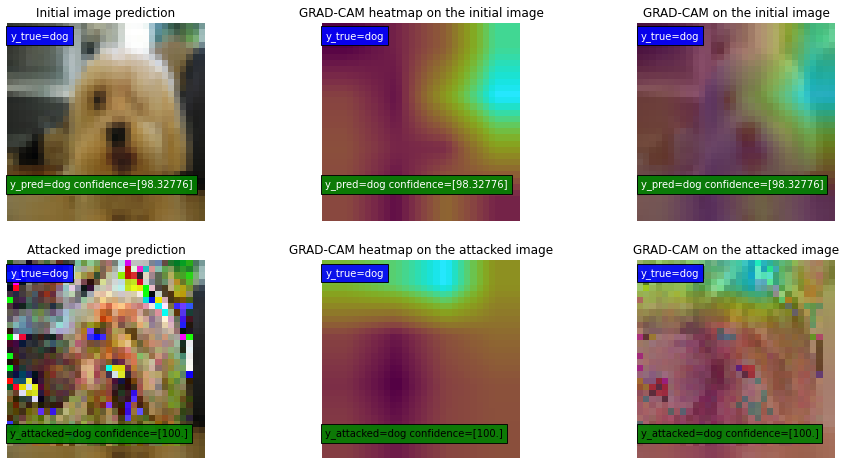

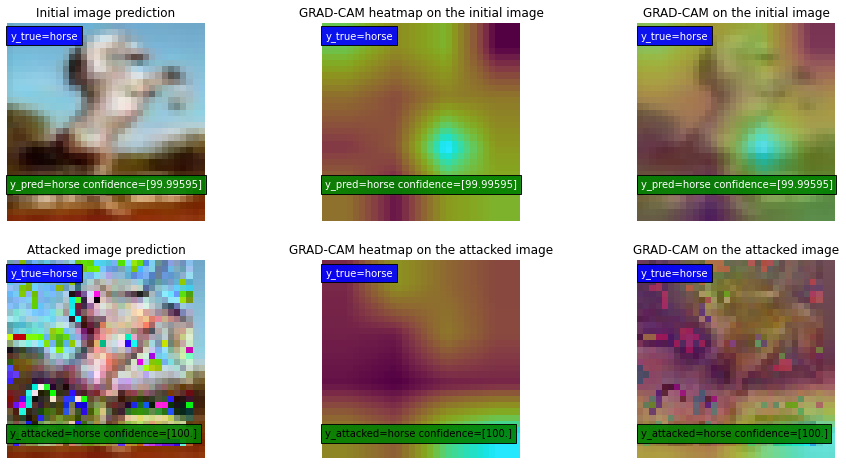

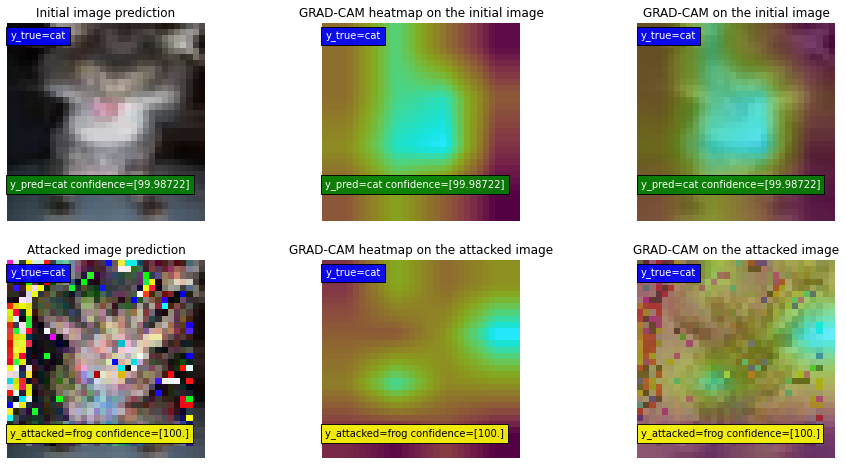

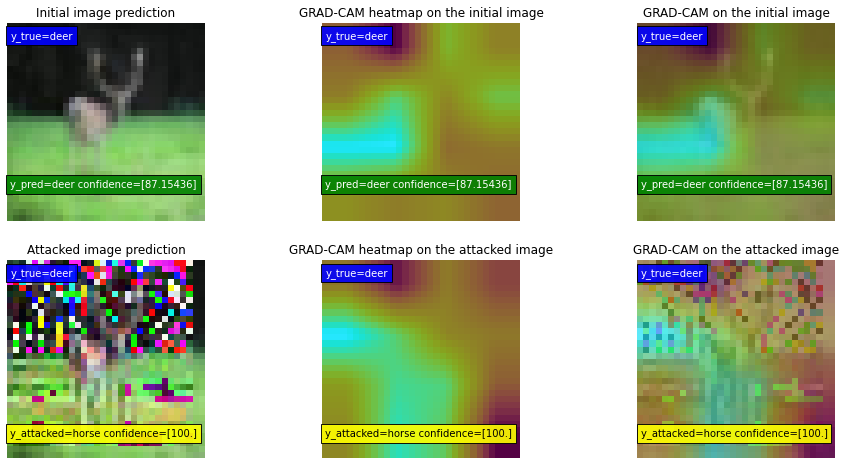

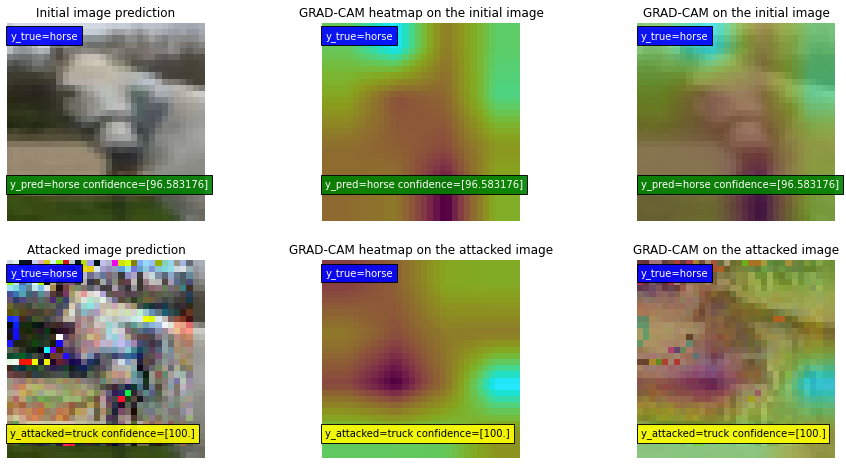

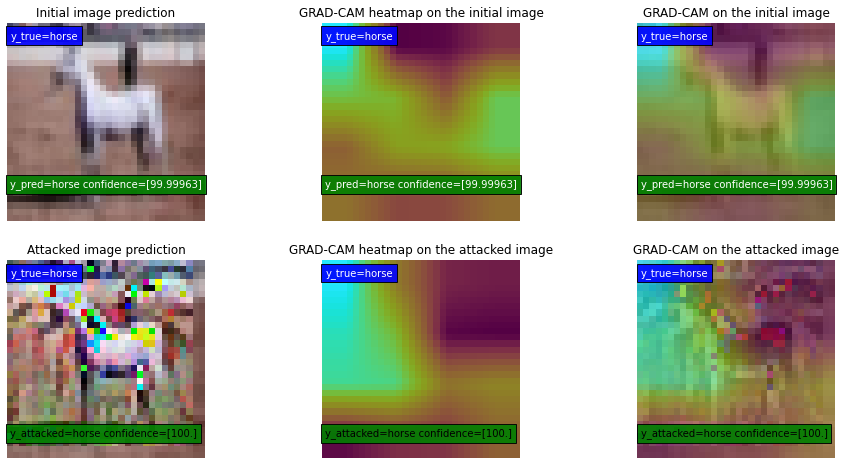

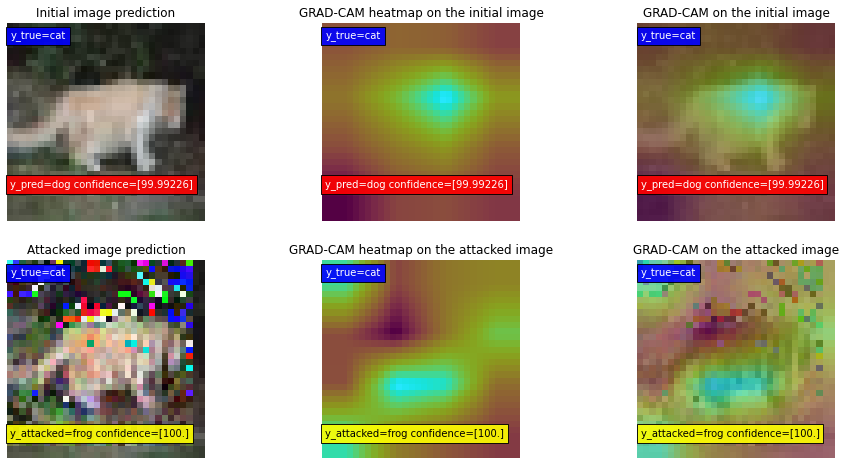

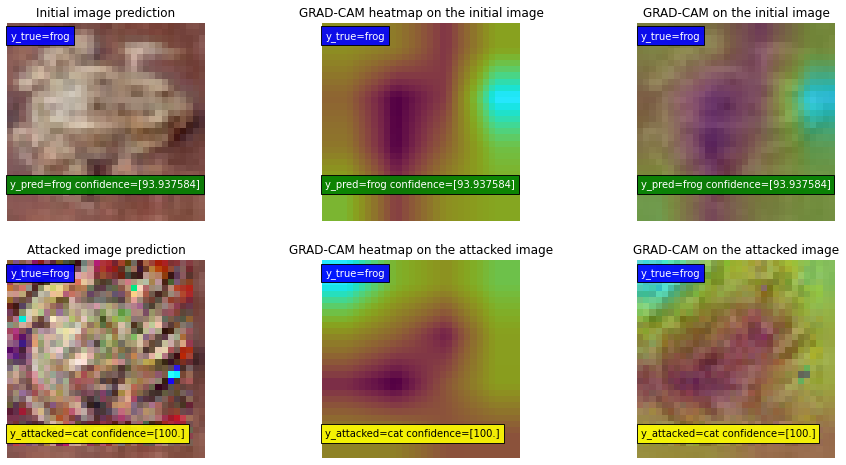

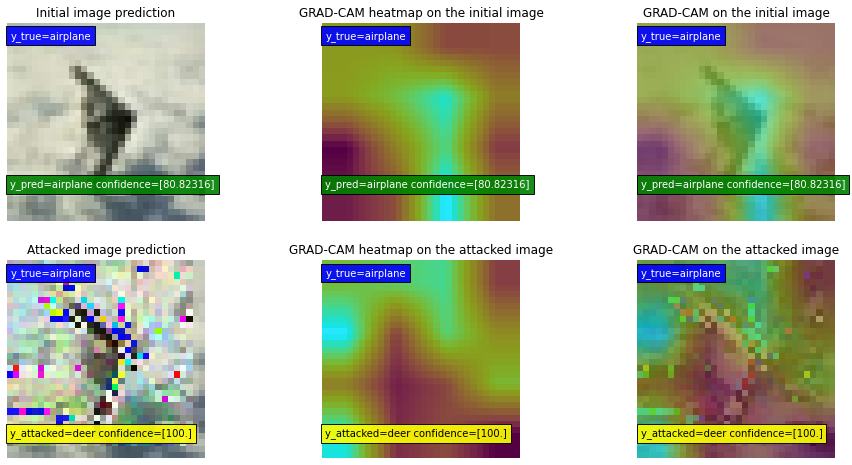

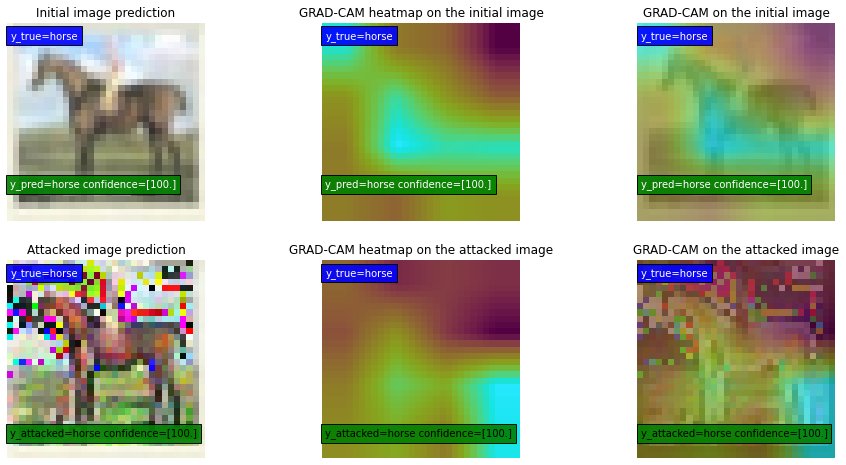

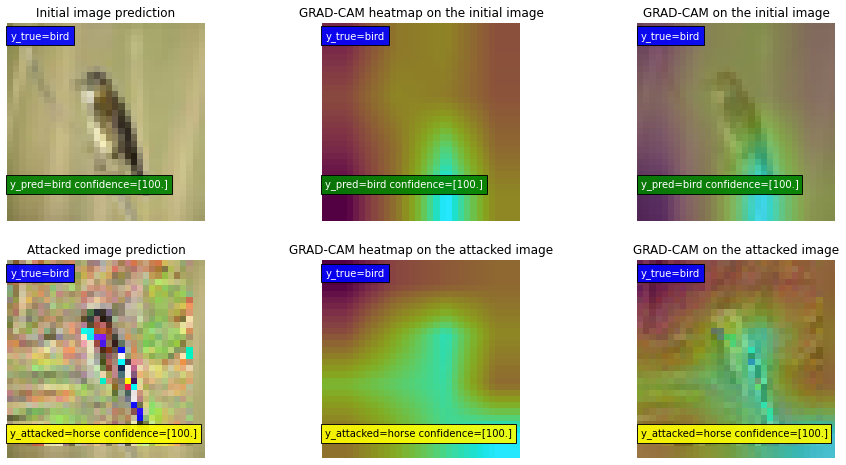

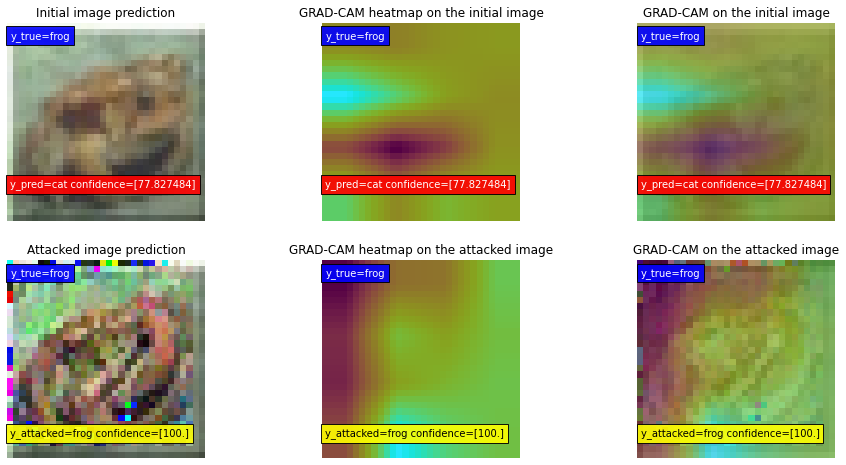

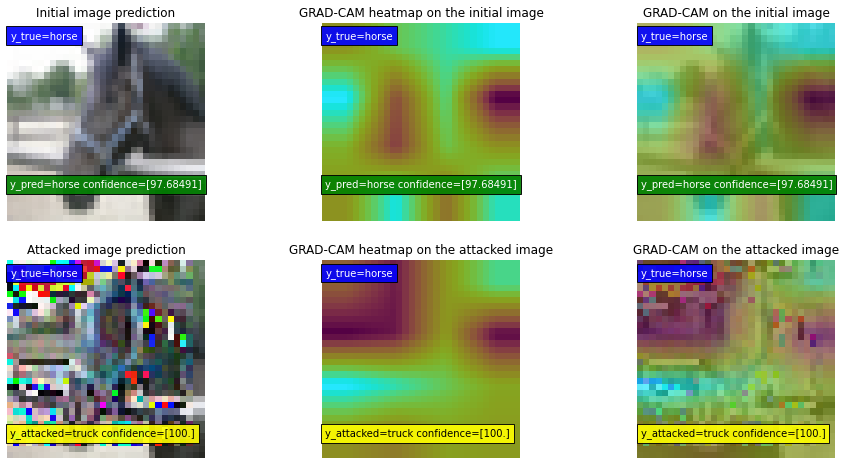

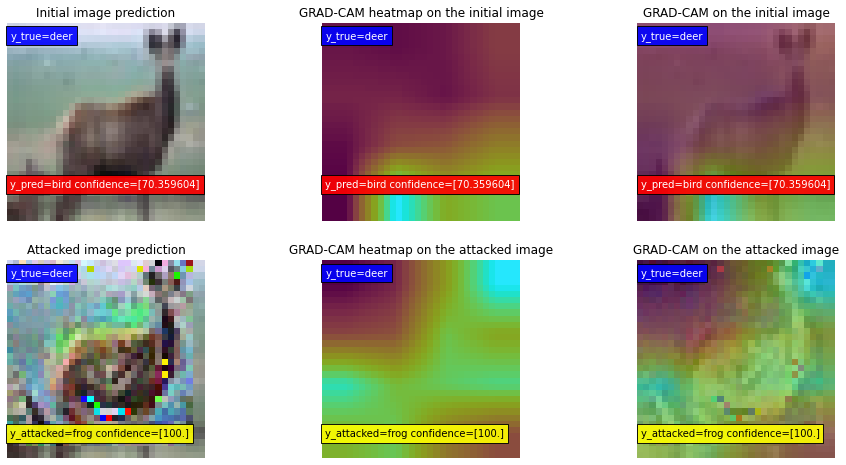

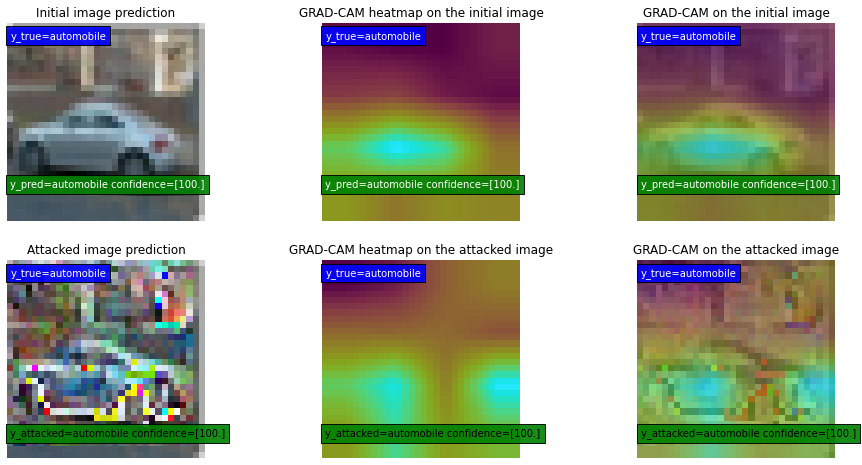

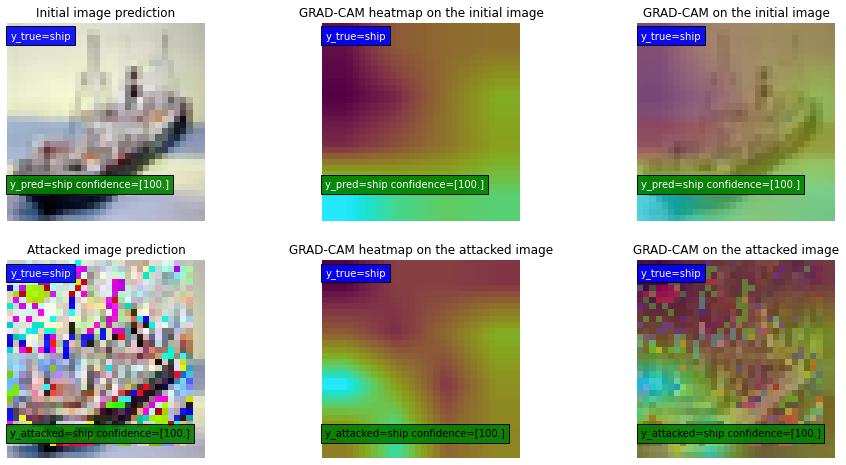

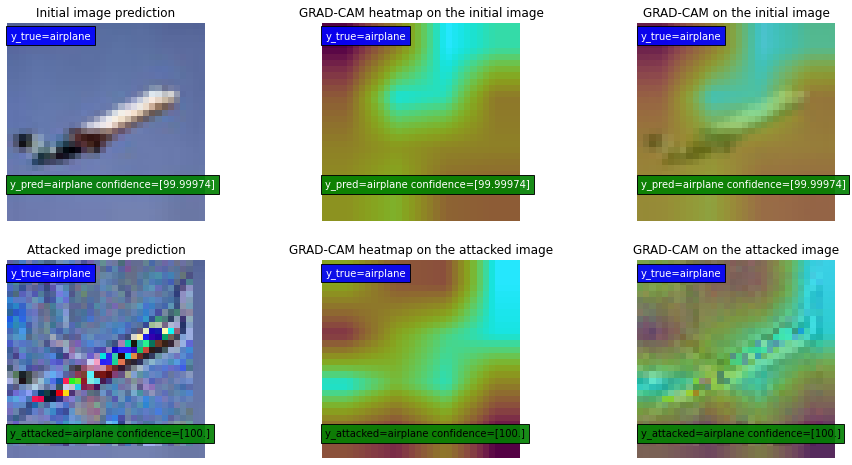

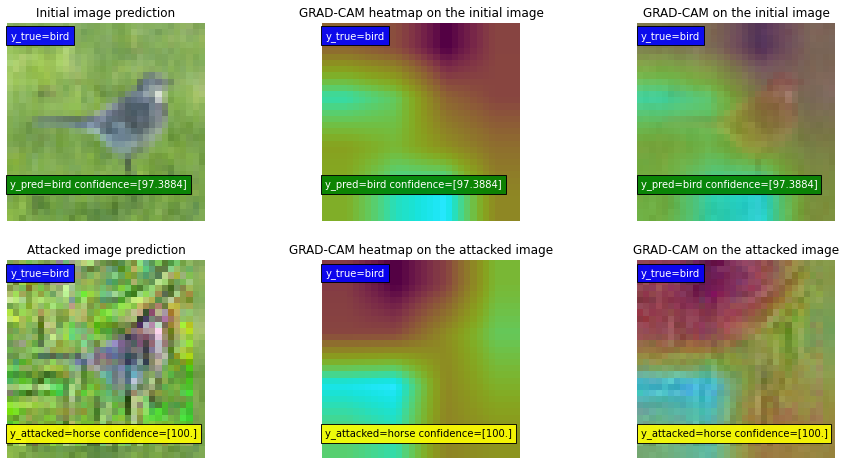

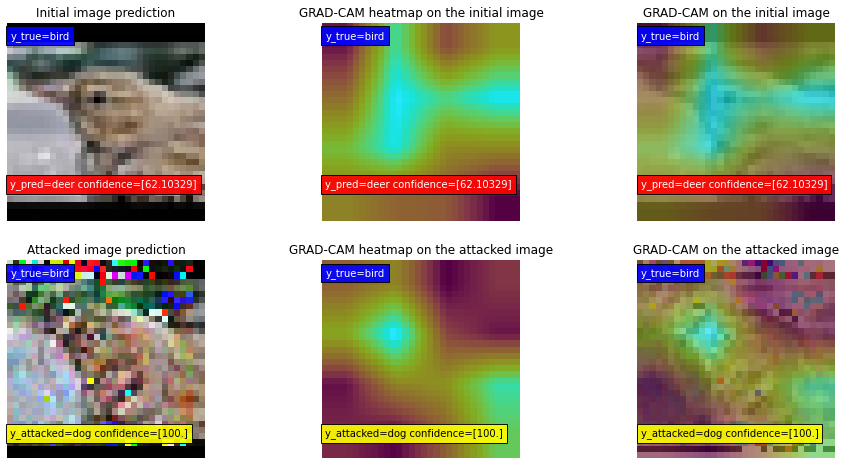

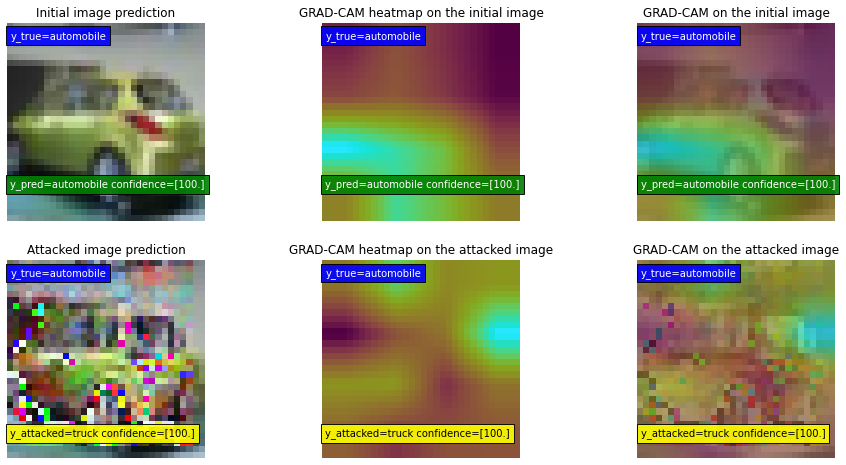

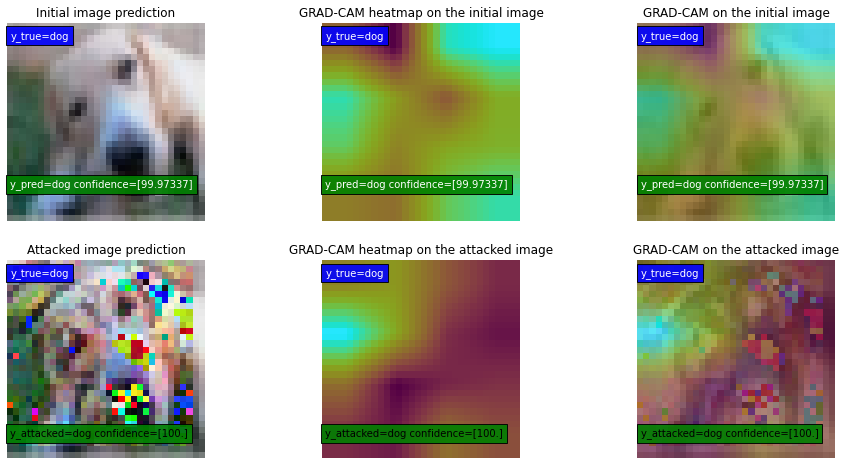

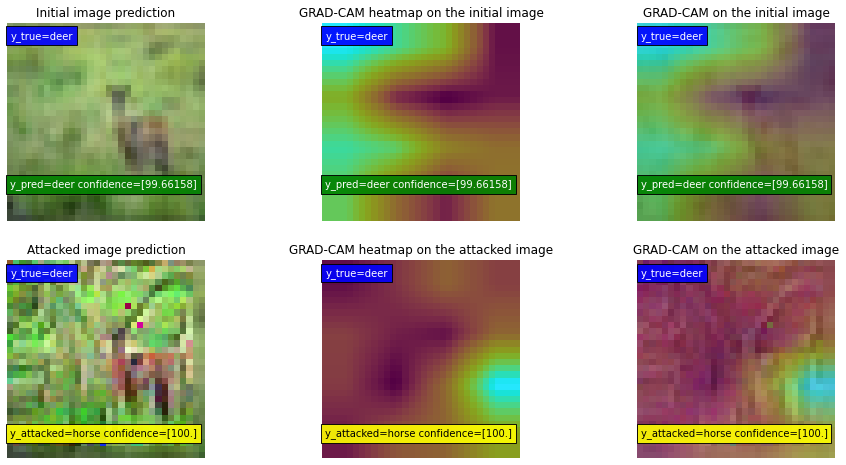

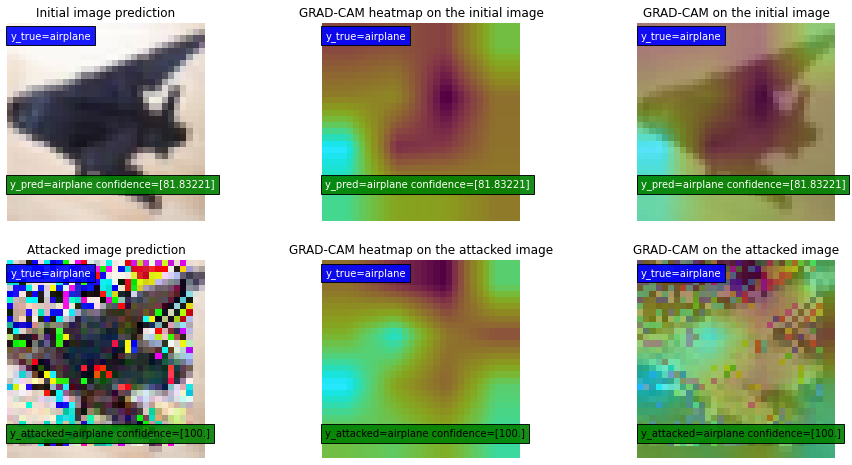

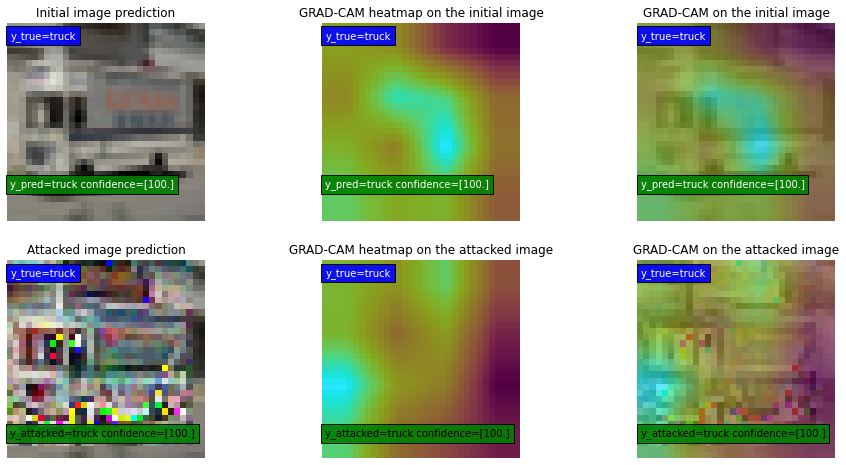

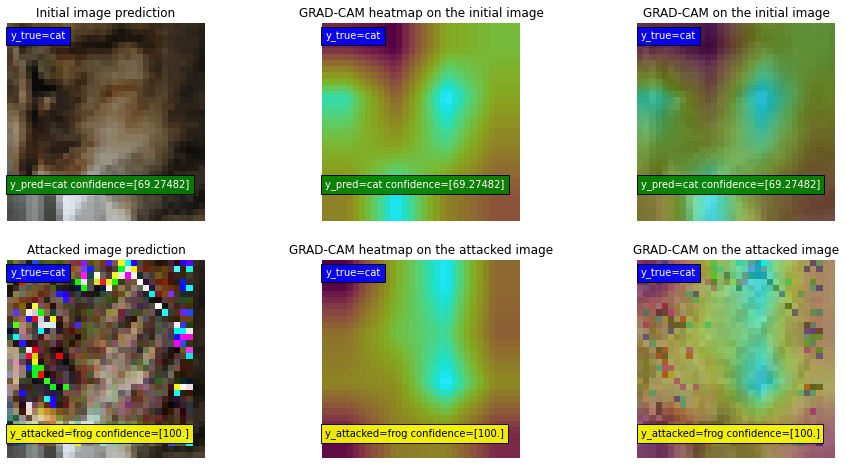

In [0]:
layer_name = 'conv2d_27'
epsilon = 30./255
eta = 6./255
n_iter = 10

img_start = 5003
img_end = 5030

pgd_grad_cam_visualization(img_start,img_end,layer_name,epsilon,eta,n_iter)

In [0]:
ind = 5011

titles = ["Initial image prediction",
          "GRAD-CAM heatmap on the initial image",
          "GRAD-CAM on the initial image",
          "Attacked image prediction",
          "GRAD-CAM heatmap on the attacked image",
          "GRAD-CAM on the attacked image",
          "Attacked image prediction initial label prediction",
          "GRAD-CAM heatmap on the attacked image initial label prediction",
          "GRAD-CAM on the attacked image initial label prediction"]


l = []
#Initial image
image = x_test[ind]
l.append(np.uint8(image*255))
num_label = y_test[ind][0]
gc = grad_cam(model_init,layer_name,image,num_label)
l.append(gc[0])
l.append(gc[1])

#attacked image
attack = Attack(model_init)
adv_image = np.uint8(attack.pgd(image,y_test[ind],epsilon,eta,n_iter)*255)
l.append(adv_image)


predicted_label = np.argmax(model_init(tf.expand_dims(image,0)))
confidence = tf.math.softmax(model_init(tf.expand_dims(image,0)))[:,predicted_label]*100

predicted_label_attack = np.argmax(model_init(tf.expand_dims(adv_image,0)))
confidence_attack = tf.math.softmax(model_init(tf.expand_dims(adv_image,0)))[:,predicted_label_attack]*100

confifence_attack_initial_label = tf.math.softmax(model_init(tf.expand_dims(adv_image,0)))[:,num_label]*100

gc_adv = grad_cam(model_init,layer_name,adv_image,np.argmax(model_init(tf.expand_dims(adv_image,0))))
l.append(gc_adv[0])
l.append(gc_adv[1])


gc_adv_initial_label = grad_cam(model_init,layer_name,adv_image,num_label)
l.append(adv_image)
l.append(gc_adv_initial_label[0])
l.append(gc_adv_initial_label[1])


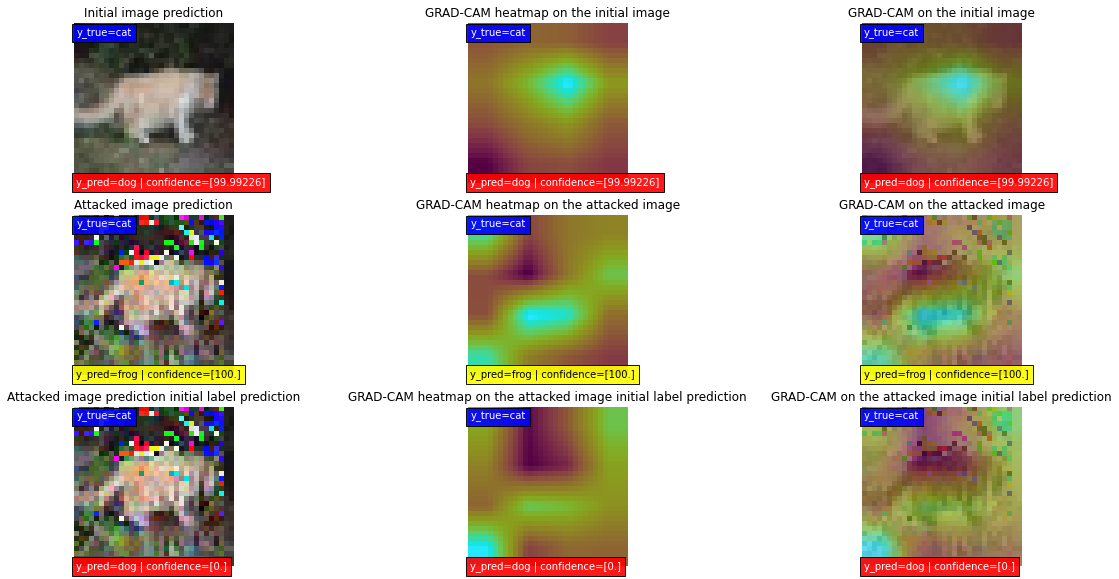

In [0]:
fig = plt.figure(figsize=(20, 10))

for i in range(0,9):
  #if i in range(0,3):
  plt.subplot(3, 3, i + 1)
  plt.text(0, 2, s=f"y_true={labels[num_label]}",
        bbox=dict(facecolor='blue', alpha=0.9),
        color="white")
  plt.imshow(l[i])

  if i in range(0,3):
    color = "green" if predicted_label == num_label else "red"
    plt.text(0, 32, s=f"y_pred={labels[predicted_label]} | confidence={confidence}",
          bbox=dict(facecolor=color, alpha=0.9),
          color="white")

  if i in range(3,6):
    color_adv = "green" if predicted_label == predicted_label_attack else "yellow"
    plt.text(0, 32, s=f"y_pred={labels[predicted_label_attack]} | confidence={confidence_attack}",
          bbox=dict(facecolor=color_adv, alpha=0.9),
          color="black")
  if i in range(6,9):
    color_adv = "green" if predicted_label == predicted_label_attack else "yellow"
    plt.text(0, 32, s=f"y_pred={labels[predicted_label]} | confidence={confifence_attack_initial_label}",
          bbox=dict(facecolor="red", alpha=0.9),
          color="white")
  plt.title(titles[i],fontdict={'fontsize':12})
  plt.axis("off")
plt.show()
  

In [0]:
grad_model = tf.keras.models.Model([model1.input], [model1.get_layer(name= 'average_pooling2d_6').output,model1.output])

with tf.GradientTape() as g:
    conv_outputs,predictions = grad_model(np.array([img]))
    loss = predictions[:, num_label]
    
    
output = conv_outputs[0]
grads = g.gradient(loss, conv_outputs)[0]



gate_f = tf.cast(output > 0, 'float32')
gate_r = tf.cast(grads > 0, 'float32')
guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

weights = tf.reduce_mean(guided_grads, axis=(0, 1))

cam = np.ones(output.shape[0: 2], dtype = np.float32)

for i, w in enumerate(weights):
    cam += w * output[:, :, i]

cam = cv2.resize(cam.numpy(), (32, 32))
cam = np.maximum(cam, 0)
heatmap = (cam - cam.min()) / (cam.max() - cam.min())

cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)

return output_image
#cv2.imwrite('/content/gdrive/My Drive/Thesis/Data/2019/img.png', output_image)

In [0]:
import cv2
import numpy as np
import tensorflow as tf



def grad_cam(model,image,num_label,layer_name) : 

    LAYER_NAME = layer_name

    img = image

    CAT_CLASS_INDEX = num_label

    grad_model = tf.keras.models.Model([model.input], [model.get_layer(name= LAYER_NAME).output,model.output])

    with tf.GradientTape() as g:
        conv_outputs,predictions = grad_model(np.array([img]))
        loss = predictions[:, num_label]
        
        
    output = conv_outputs[0]
    grads = g.gradient(loss, conv_outputs)[0]



    gate_f = tf.cast(output > 0, 'float32')
    gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))

    cam = np.ones(output.shape[0: 2], dtype = np.float32)

    for i, w in enumerate(weights):
        cam += w * output[:, :, i]

    cam = cv2.resize(cam.numpy(), (32, 32))
    cam = np.maximum(cam, 0)
    heatmap = (cam - cam.min()) / (cam.max() - cam.min())

    cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

    output_image = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.5, cam, 1, 0)

    return output_image
    #cv2.imwrite('/content/gdrive/My Drive/Thesis/Data/2019/img.png', output_image)

# Running time for the attacks

Attacking image by image

In [0]:
eta = 2/255
epsilon = 8/255
n_iter = 10 


attack = Attack(model_init)
%timeit adv = np.array([attack.pgd(x_test[i],y_test[i],epsilon,eta,n_iter) for i in tqdm.notebook.tqdm(range(len(x_test)))])

Attacking by batch

In [0]:

eta = 2/255
epsilon = 8/255
n_iter = 10 
attack_batch = Attack_batch(model_init)
%timeit adv_batch = attack_batch.pgd(x_test,y_test,epsilon,eta,n_iter)


1 loop, best of 3: 5.26 s per loop
